In [1]:
# LSTM on MNIST
# Thanks https://github.com/python-engineer, learned a lot!

import torch
import torch.nn as nn
import torchvision # for datasets
from torchvision import datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # run on gpu is possible

def load_MNIST(data_path='../data/'):
    """
    Return MNIST train and val dataset
    """
    MNIST_train = datasets.MNIST(
        data_path,       
        train=True,      
        download=False,   
        transform=transforms.Compose([
            transforms.CenterCrop(20),
            transforms.Grayscale(),
            transforms.ToTensor(),
        ]))

    MNIST_test = datasets.MNIST(
        data_path, 
        train=False,      
        download=False,   
        transform=transforms.Compose([
            transforms.CenterCrop(20),
            transforms.Grayscale(),
            transforms.ToTensor(),
        ]))

    print('Size of the training dataset: ', len(MNIST_train))
    print('Size of the validation dataset: ', len(MNIST_test))

    return MNIST_train, MNIST_test

MNIST_train, MNIST_test = load_MNIST()

Size of the training dataset:  60000
Size of the validation dataset:  10000
C:\Users\hmaan\anaconda3\envs\ml\lib\site-packages\torch\cuda\__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
# Load data
batch_size = 100

train_loader = torch.utils.data.DataLoader(MNIST_train, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(MNIST_test, batch_size=batch_size, shuffle=False)

examples = iter(train_loader)
samples, lables = examples.next()
print(samples.shape)
print(lables.shape)

torch.Size([100, 1, 20, 20])
torch.Size([100])


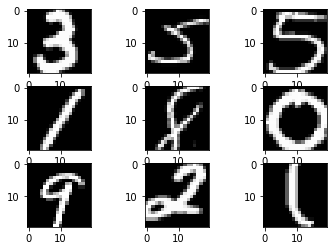

In [3]:
# Inspect images

for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(samples[i][0],cmap = 'gray')
plt.show()

In [4]:
# Hyperparameters

input_size = 20 # Each row at a time 400 # image 20x20
seq_length = 20
num_layers = 2

hidden_size = 128 # try arbitrary value given by engineer
num_classes = 10 # integers 0-9
num_epochs = 5
learning_rate = 0.001

In [5]:
# Network

class MyLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(MyLSTM, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first = True)
        # x -> batch_size, seq, input_size

        self.fc = nn.Linear(hidden_size, num_classes) # fully connected

    def forward(self, x):
        # initial hidden state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 

        # initial cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 

        out, _ = self.lstm(x, (h0,c0))
        # out shape: batch_size, seq_length, hidden_size
        # (N,20,128)
        out = out[:,-1,:]  # only the last time step out
        # Out (N, 128)
        out = self.fc(out)
        return out

# instantiate model
model = MyLSTM(input_size, hidden_size, num_layers, num_classes).to(device)

# loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
n_steps = len(train_loader)            # num examples
for epoch in range(num_epochs):
    for i, (images, lables) in enumerate(train_loader):

        # resize: [100, 20, 20]
        images = images.reshape(-1, seq_length, input_size).to(device)
        lables = lables.to(device)

        # forward
        outputs = model(images)            # 1: predict
        loss = criterion(outputs, lables)  # 2: calculate loss

        # backward
        optimizer.zero_grad()   # 1: empty vals in gradient
        loss.backward()         # 2: backpropagation
        optimizer.step()        # 3: update parameters

        # print info
        if (i+1) % 100 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_steps}], Loss: {loss.item():.4f}')

# Test and eval accuracy
with torch.no_grad():
    n_correct = 0
    n_samples = 0

    for images, lables in test_loader:
        # resize: [100, 20, 20]
        images = images.reshape(-1,seq_length, input_size).to(device)
        lables = lables.to(device)
        outputs = model(images)

        # value, index
        _, predictions = torch.max(outputs, 1)
        n_samples += lables.shape[0]
        n_correct += (predictions == lables).sum().item()
    acc = n_correct / n_samples
    print(f'Prediction accuracy = {acc}')
    

Epoch [1/5], Step [100/600], Loss: 0.6215
Epoch [1/5], Step [200/600], Loss: 0.2061
Epoch [1/5], Step [300/600], Loss: 0.2545
Epoch [1/5], Step [400/600], Loss: 0.3309
Epoch [1/5], Step [500/600], Loss: 0.1243
Epoch [1/5], Step [600/600], Loss: 0.0793
Epoch [2/5], Step [100/600], Loss: 0.1608
Epoch [2/5], Step [200/600], Loss: 0.0899
Epoch [2/5], Step [300/600], Loss: 0.1130
Epoch [2/5], Step [400/600], Loss: 0.1033
Epoch [2/5], Step [500/600], Loss: 0.1997
Epoch [2/5], Step [600/600], Loss: 0.0780
Epoch [3/5], Step [100/600], Loss: 0.0828
Epoch [3/5], Step [200/600], Loss: 0.0744
Epoch [3/5], Step [300/600], Loss: 0.0871
Epoch [3/5], Step [400/600], Loss: 0.1229
Epoch [3/5], Step [500/600], Loss: 0.0131
Epoch [3/5], Step [600/600], Loss: 0.0884
Epoch [4/5], Step [100/600], Loss: 0.0923
Epoch [4/5], Step [200/600], Loss: 0.0345
Epoch [4/5], Step [300/600], Loss: 0.0738
Epoch [4/5], Step [400/600], Loss: 0.0279
Epoch [4/5], Step [500/600], Loss: 0.0301
Epoch [4/5], Step [600/600], Loss: